In [1]:
# Block 1 — Imports, paths, and setup

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 120)

# Paths
BASE_DIR = r"C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta"
FEATURES_FP = os.path.join(BASE_DIR, "features.csv")
TARGET_MULTI_FP = os.path.join(BASE_DIR, "target_multiclass.csv")
TRAIN_IDX_FP = os.path.join(BASE_DIR, "train_indexes.csv")
VALID_IDX_FP = os.path.join(BASE_DIR, "valid_indexes.csv")
TEST_IDX_FP  = os.path.join(BASE_DIR, "test_indexes.csv")

print("Paths ready.")


Paths ready.


In [2]:
# Block 2 — Load data and align splits

# Load features and multi-class one-hot labels
X = pd.read_csv(FEATURES_FP)
Y_multi = pd.read_csv(TARGET_MULTI_FP)  # one-hot columns for each diagnosis

# Helper to read index lists robustly (skips headers if present)
def read_idx(fp):
    df = pd.read_csv(fp)
    col = df.columns[0]
    out = []
    for v in df[col].tolist():
        try:
            out.append(int(v))
        except Exception:
            continue
    return out

train_idx = read_idx(TRAIN_IDX_FP)
valid_idx = read_idx(VALID_IDX_FP)
test_idx  = read_idx(TEST_IDX_FP)

# Build splits
X_train, X_valid, X_test = X.iloc[train_idx], X.iloc[valid_idx], X.iloc[test_idx]
Y_train, Y_valid, Y_test = Y_multi.iloc[train_idx], Y_multi.iloc[valid_idx], Y_multi.iloc[test_idx]

print("Shapes:")
print("X:", X.shape, "Y_multi:", Y_multi.shape)
print("Train:", X_train.shape, Y_train.shape)
print("Valid:", X_valid.shape, Y_valid.shape)
print("Test :", X_test.shape,  Y_test.shape)

# Class names for multi-class setting
class_names = list(Y_multi.columns)
print("\n#Classes:", len(class_names))


Shapes:
X: (1011, 37) Y_multi: (1011, 20)
Train: (413, 37) (413, 20)
Valid: (203, 37) (203, 20)
Test : (395, 37) (395, 20)

#Classes: 20


In [3]:
# Block 3 — Prepare encoded features for scikit-learn trees
# DecisionTreeClassifier requires numeric inputs. One-hot encode object columns.

obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Object (categorical) columns:", obj_cols)

X_ohe = pd.get_dummies(X, drop_first=True)

# Recreate encoded splits
X_train_ohe = X_ohe.iloc[train_idx].reset_index(drop=True)
X_valid_ohe = X_ohe.iloc[valid_idx].reset_index(drop=True)
X_test_ohe  = X_ohe.iloc[test_idx].reset_index(drop=True)

print("Encoded feature matrix shape:", X_ohe.shape)


Object (categorical) columns: []
Encoded feature matrix shape: (1011, 37)


Binary label counts (train):
is_melanoma
0    323
1     90
Name: count, dtype: int64


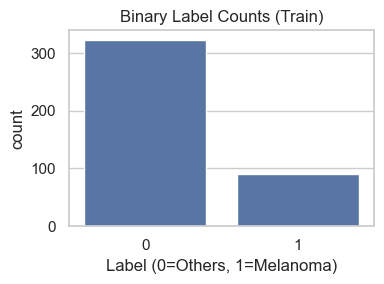

In [4]:
# Block 4A — Binary labels (melanoma vs others) + imbalance check

melanoma_labels = {
    "melanoma",
    "melanoma (less than 0.76 mm)",
    "melanoma (in situ)",
    "melanoma (0.76 to 1.5 mm)",
    "melanoma (more than 1.5 mm)",
    "melanoma metastasis"
}

# Derive binary from one-hot Y_multi (map any melanoma subtype to 1)
is_melanoma = np.zeros(len(Y_multi), dtype=int)

for col in Y_multi.columns:
    if any(k in col.lower() for k in ["melanoma"]):
        is_melanoma = np.maximum(is_melanoma, Y_multi[col].values)

# Convert to pandas Series to match indexing and for easy splitting
y_bin = pd.Series(is_melanoma, index=Y_multi.index, name="is_melanoma")

# Split by saved indices
y_train_bin = y_bin.iloc[train_idx].reset_index(drop=True)
y_valid_bin = y_bin.iloc[valid_idx].reset_index(drop=True)
y_test_bin  = y_bin.iloc[test_idx].reset_index(drop=True)

print("Binary label counts (train):")
print(y_train_bin.value_counts())

# Plot imbalance on train
plt.figure(figsize=(4,3))
sns.countplot(x=y_train_bin)
plt.title("Binary Label Counts (Train)")
plt.xlabel("Label (0=Others, 1=Melanoma)")
plt.tight_layout()
plt.show()



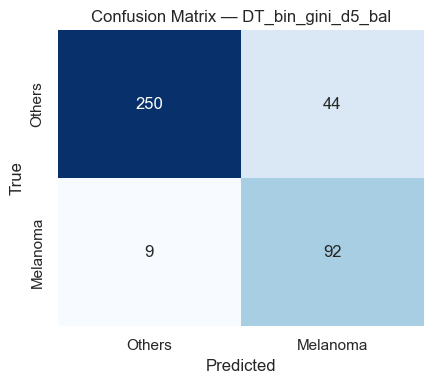

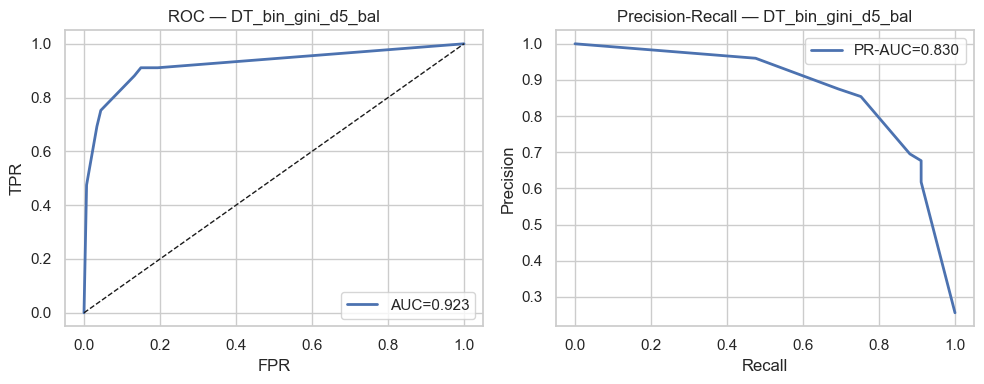

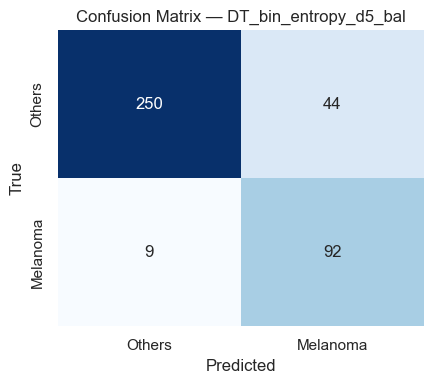

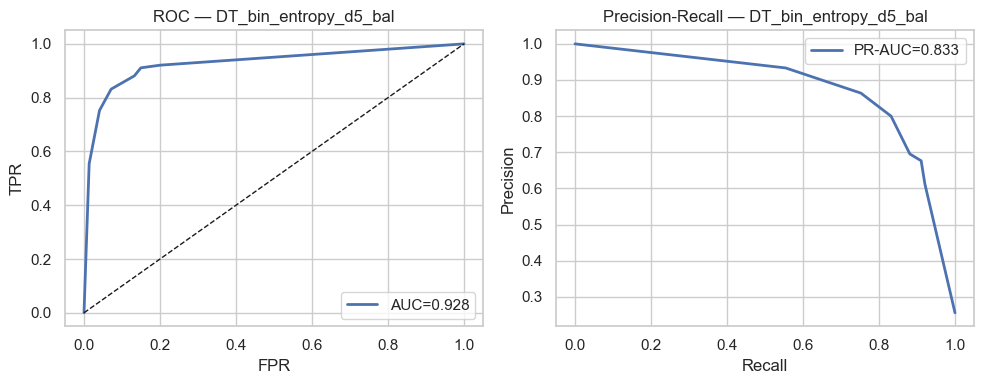

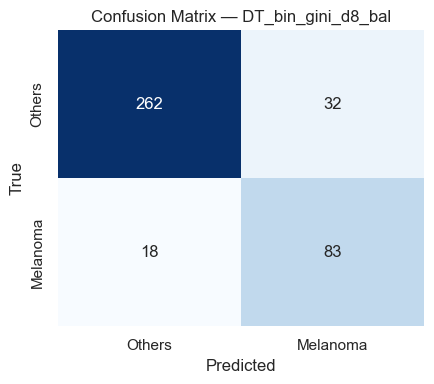

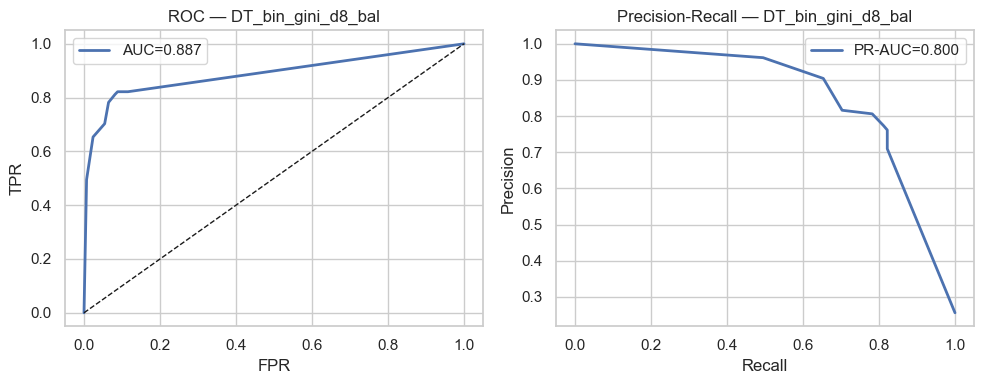

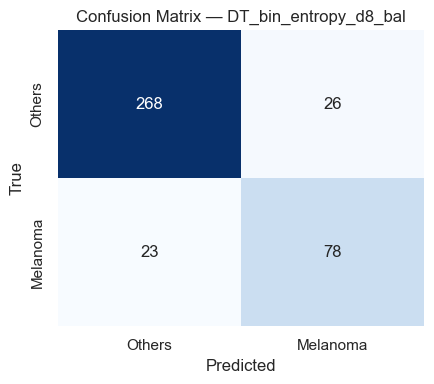

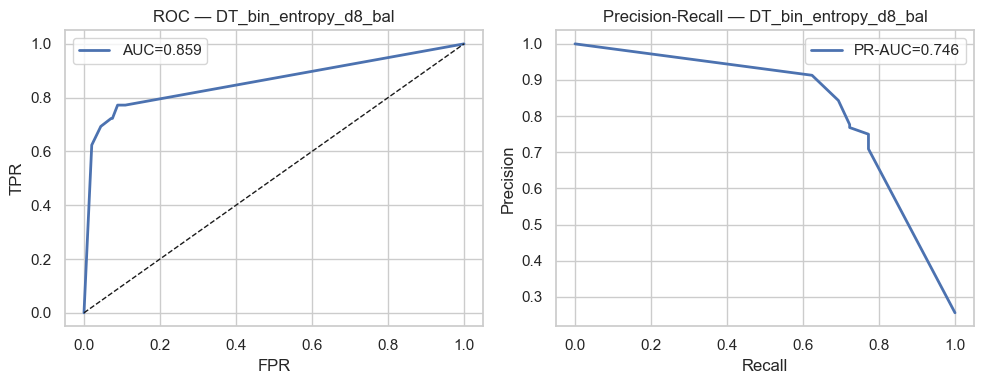

Binary Decision Tree results (test):


,Model,Accuracy,F1,ROC-AUC,PR-AUC
0,DT_bin_gini_d5_bal,0.8658,0.7764,0.9228,0.8299
1,DT_bin_entropy_d5_bal,0.8658,0.7764,0.9279,0.8327
2,DT_bin_gini_d8_bal,0.8734,0.7685,0.8868,0.7996
3,DT_bin_entropy_d8_bal,0.8759,0.7610,0.8594,0.7464


In [5]:
# Block 5A — Binary DT variants: evaluate gini vs entropy, with class_weight='balanced'

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

variants = [
    {"name": "DT_bin_gini_d5_bal",    "params": dict(criterion="gini",    max_depth=5,  random_state=42, class_weight="balanced")},
    {"name": "DT_bin_entropy_d5_bal", "params": dict(criterion="entropy", max_depth=5,  random_state=42, class_weight="balanced")},
    {"name": "DT_bin_gini_d8_bal",    "params": dict(criterion="gini",    max_depth=8,  random_state=42, class_weight="balanced")},
    {"name": "DT_bin_entropy_d8_bal", "params": dict(criterion="entropy", max_depth=8,  random_state=42, class_weight="balanced")},
]

bin_rows = []

for v in variants:
    clf = DecisionTreeClassifier(**v["params"])
    clf.fit(X_train_ohe, y_train_bin)
    y_pred = clf.predict(X_test_ohe)
    y_prob = clf.predict_proba(X_test_ohe)[:, 1]

    acc  = accuracy_score(y_test_bin, y_pred)
    f1   = f1_score(y_test_bin, y_pred, average="binary", zero_division=0)
    auc  = roc_auc_score(y_test_bin, y_prob)
    pr_auc = average_precision_score(y_test_bin, y_prob)

    bin_rows.append({"Model": v["name"], "Accuracy": acc, "F1": f1, "ROC-AUC": auc, "PR-AUC": pr_auc})

    # Confusion matrix
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Others","Melanoma"], yticklabels=["Others","Melanoma"])
    plt.title(f"Confusion Matrix — {v['name']}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # ROC + PR curves
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    prec, rec, _ = precision_recall_curve(y_test_bin, y_prob)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], 'k--', lw=1)
    plt.title(f"ROC — {v['name']}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rec, prec, lw=2, label=f"PR-AUC={pr_auc:.3f}")
    plt.title(f"Precision-Recall — {v['name']}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plt.tight_layout(); plt.show()

bin_results = pd.DataFrame(bin_rows).sort_values(by="F1", ascending=False)
print("Binary Decision Tree results (test):")
display(bin_results.round(4))


In [6]:
# ==============================================================
# Block 5C — Best Binary Decision Tree Model Summary
# ==============================================================

if "bin_results" in locals() and not bin_results.empty:
    # Identify best models by F1 and AUC
    best_f1_model = bin_results.loc[bin_results["F1"].idxmax()]
    best_auc_model = bin_results.loc[bin_results["ROC-AUC"].idxmax()]

    print("🔹 Best Binary Decision Tree Models Summary 🔹\n")
    print(f"Highest F1 Score Model: {best_f1_model['Model']}")
    print(f"  - Accuracy: {best_f1_model['Accuracy']:.3f}")
    print(f"  - F1 Score: {best_f1_model['F1']:.3f}")
    print(f"  - ROC-AUC : {best_f1_model['ROC-AUC']:.3f}")
    print(f"  - PR-AUC  : {best_f1_model['PR-AUC']:.3f}\n")

    print(f"Highest ROC-AUC Model: {best_auc_model['Model']}")
    print(f"  - Accuracy: {best_auc_model['Accuracy']:.3f}")
    print(f"  - F1 Score: {best_auc_model['F1']:.3f}")
    print(f"  - ROC-AUC : {best_auc_model['ROC-AUC']:.3f}")
    print(f"  - PR-AUC  : {best_auc_model['PR-AUC']:.3f}\n")

    # Compact summary table
    summary_table = pd.DataFrame({
        "Best Metric": ["F1 Score", "ROC-AUC"],
        "Model Name": [best_f1_model["Model"], best_auc_model["Model"]],
        "Score": [best_f1_model["F1"], best_auc_model["ROC-AUC"]]
    })
    display(summary_table.round(4))

else:
    print("No binary decision tree results found. Please run Block 5A first.")


🔹 Best Binary Decision Tree Models Summary 🔹

Highest F1 Score Model: DT_bin_gini_d5_bal
  - Accuracy: 0.866
  - F1 Score: 0.776
  - ROC-AUC : 0.923
  - PR-AUC  : 0.830

Highest ROC-AUC Model: DT_bin_entropy_d5_bal
  - Accuracy: 0.866
  - F1 Score: 0.776
  - ROC-AUC : 0.928
  - PR-AUC  : 0.833



,Best Metric,Model Name,Score
0,F1 Score,DT_bin_gini_d5_bal,0.7764
1,ROC-AUC,DT_bin_entropy_d5_bal,0.9279


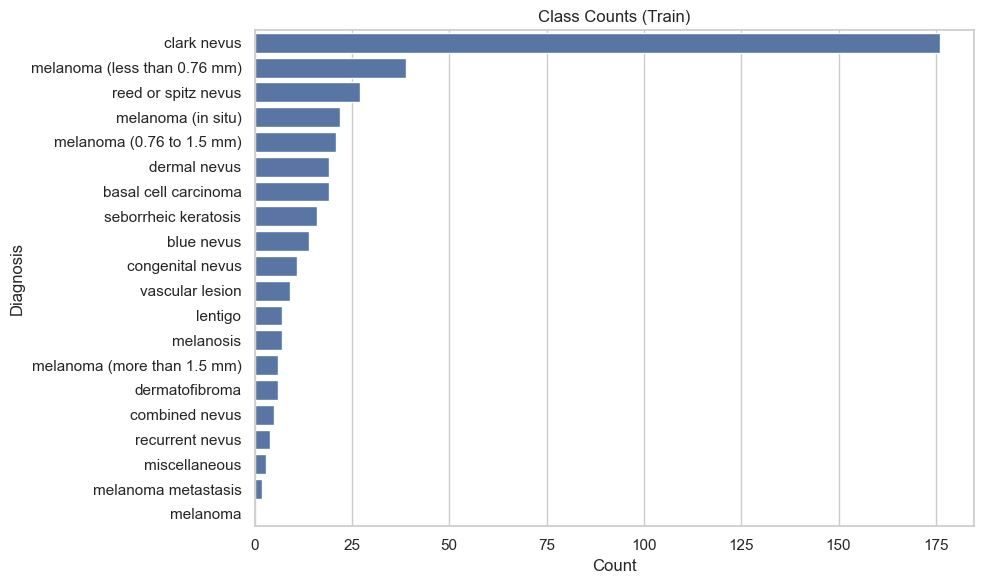

In [7]:
# Block 4B — Multi-class labels and imbalance check (on train)

y_train_mc = Y_train.values.argmax(axis=1)
y_valid_mc = Y_valid.values.argmax(axis=1)
y_test_mc  = Y_test.values.argmax(axis=1)

# Count per class (train)
train_counts = Y_train.sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=train_counts.values, y=train_counts.index, orient="h")
plt.title("Class Counts (Train)")
plt.xlabel("Count"); plt.ylabel("Diagnosis")
plt.tight_layout(); plt.show()


Validation results (multi-class sweep):


,criterion,class_weight,max_depth,val_acc,val_macroF1
3,gini,None,10,0.4778,0.3264
19,entropy,balanced,12,0.4680,0.3215
12,entropy,None,8,0.4729,0.3077
13,entropy,None,10,0.4631,0.2941
14,entropy,None,12,0.4581,0.2905
18,entropy,balanced,10,0.4138,0.2887
4,gini,None,12,0.4729,0.2857
17,entropy,balanced,8,0.3498,0.2847
2,gini,None,8,0.4975,0.2685
8,gini,balanced,10,0.3793,0.2510


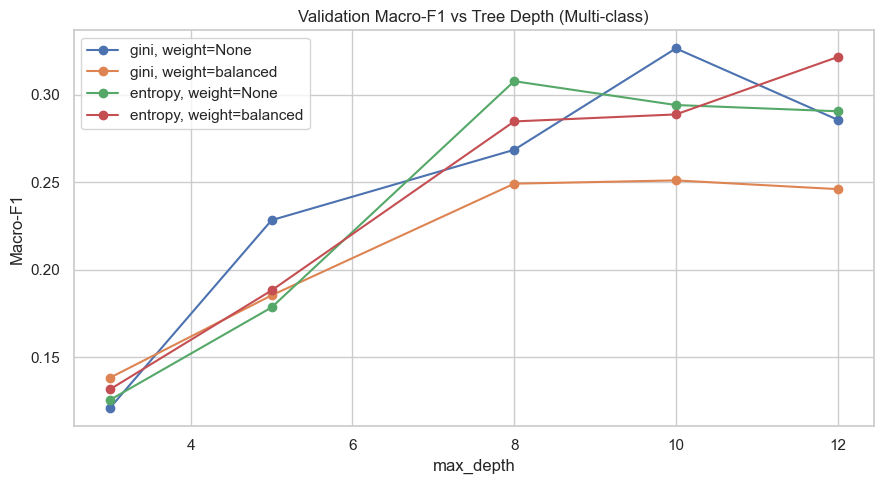

In [8]:
# Block 5B — Depth/criterion sweep for multi-class trees

depths = [3, 5, 8, 10, 12]
criteria = ["gini", "entropy"]
weights = [None, "balanced"]  # to study imbalance effect

rows = []
for crit in criteria:
    for w in weights:
        for d in depths:
            clf = DecisionTreeClassifier(
                criterion=crit,
                max_depth=d,
                random_state=42,
                class_weight=w
            )
            clf.fit(X_train_ohe, y_train_mc)
            y_pred_val = clf.predict(X_valid_ohe)  # select by validation
            acc = accuracy_score(y_valid_mc, y_pred_val)
            f1  = f1_score(y_valid_mc, y_pred_val, average="macro", zero_division=0)

            rows.append({
                "criterion": crit, "class_weight": str(w),
                "max_depth": d, "val_acc": acc, "val_macroF1": f1
            })

sweep_df = pd.DataFrame(rows)
print("Validation results (multi-class sweep):")
display(sweep_df.sort_values(by="val_macroF1", ascending=False).head(12).round(4))

# Plot macro-F1 vs depth for each setting
plt.figure(figsize=(9,5))
for crit in criteria:
    for w in weights:
        dfp = sweep_df[(sweep_df["criterion"]==crit) & (sweep_df["class_weight"]==str(w))]
        dfp = dfp.sort_values("max_depth")
        label = f"{crit}, weight={w}"
        plt.plot(dfp["max_depth"], dfp["val_macroF1"], marker="o", label=label)
plt.title("Validation Macro-F1 vs Tree Depth (Multi-class)")
plt.xlabel("max_depth"); plt.ylabel("Macro-F1")
plt.legend()
plt.tight_layout(); plt.show()


Best DT (by validation Macro-F1): {'criterion': 'gini', 'max_depth': 10, 'class_weight': None, 'random_state': 42}

Test Classification Report (Multi-class):
                              precision    recall  f1-score   support

        basal cell carcinoma       0.64      0.56      0.60        16
                  blue nevus       0.28      0.73      0.40        11
                 clark nevus       0.74      0.81      0.78       156
              combined nevus       0.33      0.20      0.25         5
            congenital nevus       0.00      0.00      0.00         4
                dermal nevus       0.57      0.50      0.53         8
              dermatofibroma       0.40      0.29      0.33         7
                     lentigo       1.00      0.25      0.40        12
                    melanoma       0.00      0.00      0.00         1
   melanoma (0.76 to 1.5 mm)       0.27      0.39      0.32        18
          melanoma (in situ)       0.35      0.23      0.28        26
m

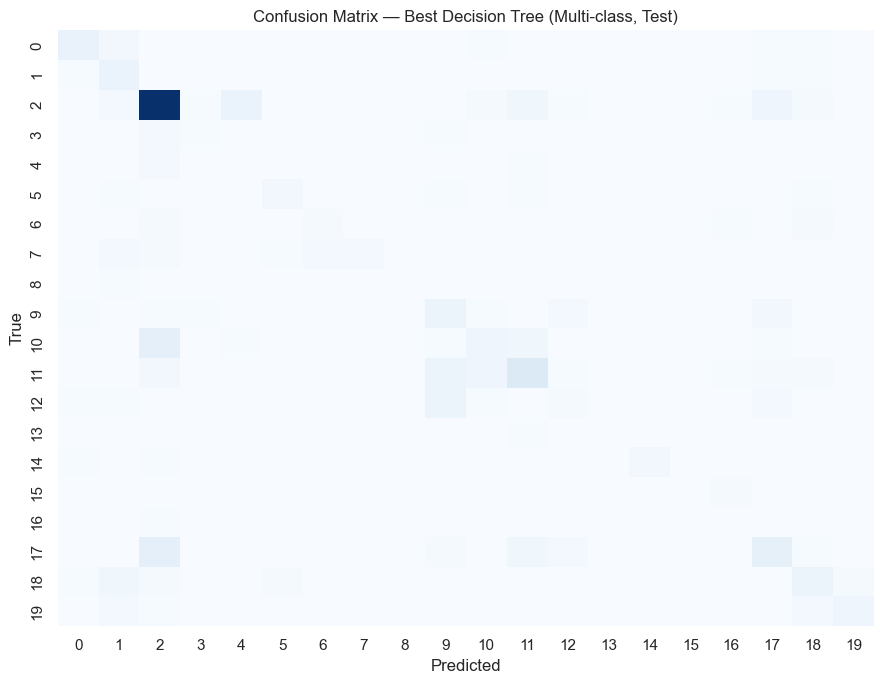

In [9]:
# Block 6B — Train best config on train, evaluate on test

best_row = sweep_df.sort_values(by="val_macroF1", ascending=False).iloc[0]
best_params = dict(
    criterion = best_row["criterion"],
    max_depth = int(best_row["max_depth"]),
    class_weight = None if best_row["class_weight"]=="None" else "balanced",
    random_state = 42
)
print("Best DT (by validation Macro-F1):", best_params)

best_dt = DecisionTreeClassifier(**best_params)
best_dt.fit(X_train_ohe, y_train_mc)
y_pred_test_mc = best_dt.predict(X_test_ohe)

print("\nTest Classification Report (Multi-class):")
print(classification_report(y_test_mc, y_pred_test_mc, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_test_mc, y_pred_test_mc)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Best Decision Tree (Multi-class, Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


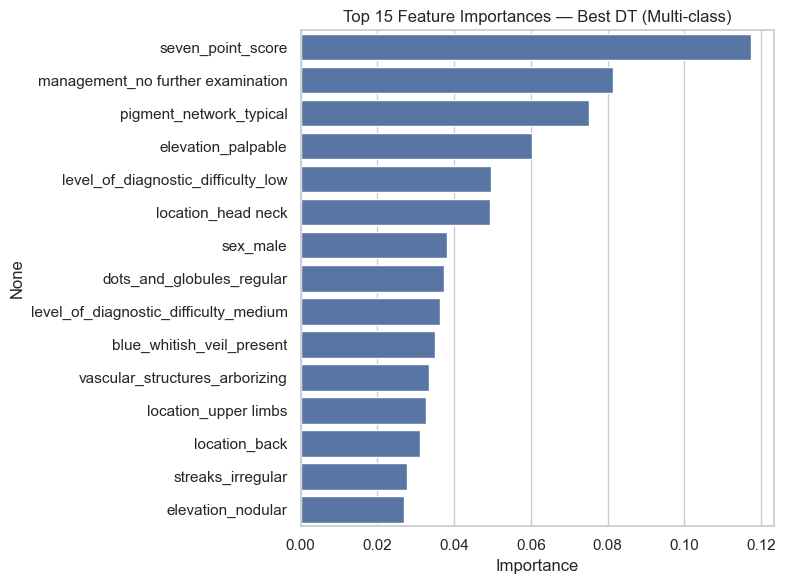

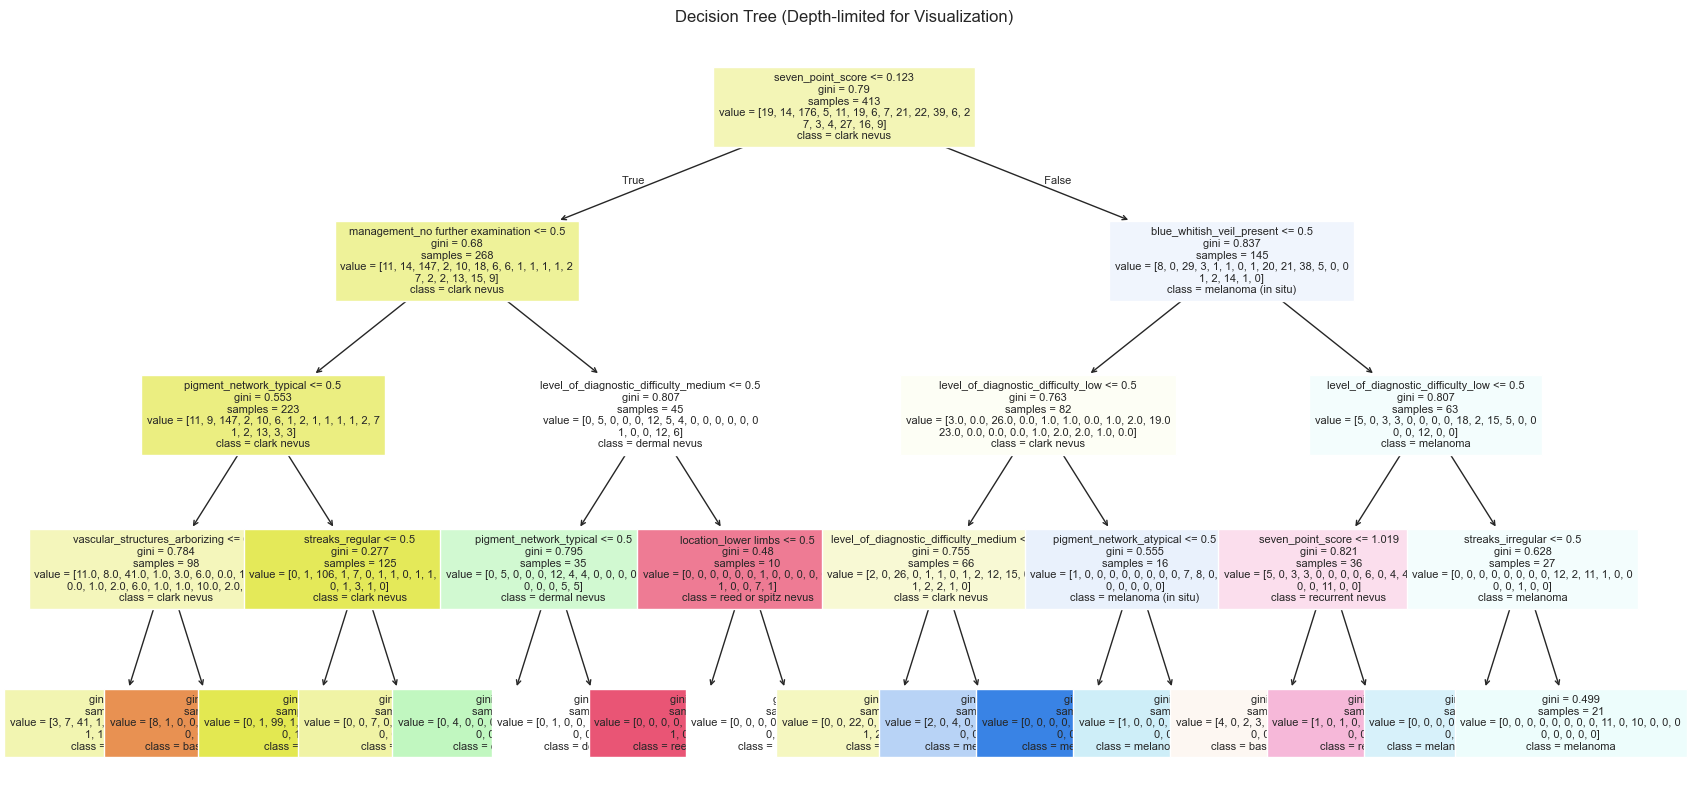

In [10]:
# Block 7 — Feature importance and shallow tree visualization

# Feature importance
fi = pd.Series(best_dt.feature_importances_, index=X_train_ohe.columns).sort_values(ascending=False)
top_fi = fi.head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_fi.values, y=top_fi.index, orient="h")
plt.title("Top 15 Feature Importances — Best DT (Multi-class)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()

# Optional: visualize a shallower tree for readability
viz_dt = DecisionTreeClassifier(
    criterion=best_params["criterion"],
    max_depth=min(4, best_params["max_depth"]),  # limit for readability
    class_weight=best_params["class_weight"],
    random_state=42
)
viz_dt.fit(X_train_ohe, y_train_mc)

plt.figure(figsize=(20,10))
plot_tree(
    viz_dt,
    feature_names=list(X_train_ohe.columns),
    class_names=class_names,
    filled=True,
    max_depth=4,
    fontsize=8
)
plt.title("Decision Tree (Depth-limited for Visualization)")
plt.show()


### Analysis Summary

**Binary (melanoma vs others):**
- Class imbalance is visible; using `class_weight="balanced"` improves recall for melanoma.
- Entropy vs Gini: similar performance; deeper trees improve fit but risk overfitting.

**Multi-class (all diagnoses):**
- Macro-F1 over validation helps select depth that balances bias/variance.
- `class_weight="balanced"` typically improves minority-class recall.
- Final test results and confusion matrix highlight which diagnoses are hardest (often rare classes).

**Next steps:**
- Try Balanced Random Forest or Gradient Boosted Trees for stronger performance.
- Use calibration (Platt/Temperature) if you’ll report calibrated probabilities.
- Proceed to fusion model: combine CNN image embeddings with selected metadata features.
